# バイアスとバリアンスについて

#### バイアスとバリアンスは、機械学習において、モデルの予測した値と真の値とのズレを評価する指針である。
#### バイアスは未学習、バリアンスは過学習を評価しており、バイアスとバリアンスを見比べることで、真の値とのずれが、未学習によるものなのか過学習によるものなのかが直感的に理解できる。

## 未学習と過学習

### 未学習とは、まだ十分な学習ができておらず、データを表現するモデルが未完成な状態のこと。全然勉強してないからテストの問題が解けない状態は未学習
### 過学習とは、訓練データを完ぺきに表現しようとするあまりに、未知のデータに対して全く識別できなくなった状態のこと。過去問やりすぎて値を変えられただけなのに解けないとか、過去問で出た問題以外解けないよという状態は過学習
### つまりバイアスとバリアンスは、データを表現するモデルが「まだ勉強不足か、やりすぎなのか」を表している。

In [4]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import math
import matplotlib.pyplot as plt
np.random.seed(seed=32)
# create samples
sample_size = 50
noise_size = 0.2

dataX = np.linspace(0.0, 5.0, num=1000).reshape((1000, 1))
x = np.random.permutation(dataX)[:sample_size]
noise = noise_size * np.random.randn(sample_size, 1)
func = np.vectorize(math.sin)
y = func(x*1.6) + noise


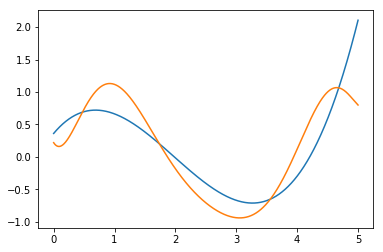

In [5]:
dim = [3, 9]
for d in dim:
    poly = PolynomialFeatures(degree=d)
    X = poly.fit_transform(x)
    XTX = np.dot(X.T, X)
    XTX_inv = np.linalg.inv(XTX)
    a = np.dot(XTX_inv, np.dot(X.T, y))
    Xt = poly.fit_transform(dataX)
    yt = np.dot(Xt, a)
    plt.plot(dataX, yt, label='%d polynomial' % d)

# バイアスとバリアンスを式から理解する(バイアス-バリアンス分解)

### > バイアス-バリアンス分解は未学習や過学習の状況を理論的に解析する手法です。
### とのことなのでせっかくなのでやってみます
### バイアス-バリアンス分解を考えるためには、まず損失関数の期待値を考えなければならない.

### 訓練データxに対する正解の値tがデータとして手元にあり、モデルy(x)という関数によって、xとtの関係を学習させる。モデルを学習させるための損失関数を二乗誤差とすると
$$
    L(y(x),t) = (y(x)-t)^2
$$
### 損失関数はこの式で表される。右辺のカッコの中身はモデルの出した答えと真の値の誤差となっている。誤差があればあるほどLは大きくなるため、Lがなるべく小さくなるようにy(x)を決定する。

### ここで、xとtというデータが得られる同時確率をp(x,t)とすると、損失関数の期待値は以下の式で表される。
$$
    E[L(y(x),t)] = \int\int(y(x)-t)^2p(x,t)dtdx
$$

### この式は確率分布の乗法方程式$ p(x,t)=p(t|x)p(x) $ によって以下の式へと変換できる
$$
    E[L(y(x),t)] = \int p(x)dx\int(y(x)-t)^2p(t|x)dt
$$
### この式より、損失の期待値が最小となるには$ \int(y(x)-t)^2p(t|x)dt $ が最小となればよく、変化させられるのはy(x)(モデルの結果)のみなので
$$
    \frac{\partial}{\partial y(x)}\int(y(x)-t)^2p(t|x)dt=0
$$
### となればよい

### 常識を変換していくと、
$$
    \frac{\partial}{\partial y(x)}\int(y(x)-t)^2p(t|x)dt
$$
$$
    =2\int(y(x)-t)p(t|x)dt
$$
$$
    =2\int y(x)p(t|x)dt-2\int tp(t|x)dt
$$
$$
    =2 y(x)\int p(t|x)dt-2\int tp(t|x)dt
$$
### ここで$\int p(t|x)dt$は1であるので
$$
    =2 y(x)-2\int tp(t|x)dt=0
$$
$$
    y(x)=\int tp(t|x)dt
$$
### ここで$\int tp(t|x)$は条件付き期待値$E(t|x)$であるので
$$
    y(x)=E(t|x)
$$
### このことから、モデルを条件付き期待値によって決めることで、損失が最小化されることが分かった

### 最適解が期待値だということがわかったので、損失関数の右辺を次のように変形することができる
$$
    L(y(x),t) = (y(x)+E[t|x]-E[t|x]-t)^2
$$
### 損失関数の右辺に$ E[t|x]-E[t|x]=0 $を加えただけである。右辺をさらに展開すると
$$
    L(y(x),t) = (y(x)+E[t|x]-E[t|x]-t)^2
$$
$$
              = ((y(x)-E[t|x])+(E[t|x]-t))^2
$$
$$
              = (y(x)-E[t|x])^2+2((y(x)-E[t|x])(E[t|x]-t))+(E[t|x]-t)^2
$$

### 展開した式を損失関数の期待値の式に代入し、tで積分すると第2項が0となる(らしい)ので損失関数の期待値は以下のようになる
$$
    E[L(y(x),t)] = \int\int(y(x)-E[t|x])^2p(x,t)dtdx+\int\int(E[t|x]-t)^2p(x,t)dtdx
$$
$$
     = \int(y(x)-E[t|x])^2dx\int p(x,t)dt+\int\int(E[t|x]-t)^2p(t|x)p(x)dtdx
$$
$$
     = \int(y(x)-E[t|x])^2p(x)dx+\int(E[t|x]-t)^2p(t|x)dt\int p(x)dx
$$
$$
     = \int(y(x)-E[t|x])^2p(x)+var[t|x]p(x)
$$
### 機械学習で変化できるのは$ y(x)$ のみであるため、この式の第1項から、損失が最小となるには$ y(x)=E(t|x)$であることがわかる

$$
   E[L(y(x),t)] = \int(y(x)-E[t|x])^2p(x)+var[t|x]p(x)
$$
### これまでで、損失の期待値が上式であることがわかったが、訓練データ集合$D[x_1,x_2...x_i]$は全ての値を取ってくることはできず、あくまでデータ集合の内の一部を取ってきているに過ぎない。そのためモデルの性能は取ってきたデータDの中身に依存してしまう。そのことを意識して期待値を以下のように書き換える。
$$
   y(x)\to y(x;D)
$$
$$
  E[t|x]\to E[t|x;D]
$$
### 書き換えた条件付き期待値とモデルを用いて損失の期待値を表すと
$$
              E_D[L(y(x;D),t)] = E_D[((y(x;D)-E[t|x;D])+(E[t|x;D]-t))^2]
$$
### 右辺の第2項はモデルが関与できない損失のため、ノイズ校と呼ばれる。そのため、第1項について考えていく
$$
              E_D[L(y(x;D),t)] = E_D[(y(x;D)-E[t|x;D])^2]
$$
### この式の右辺に$E_D[y(x;D)]-E_D[y(x;D)]=0$を差し込む
$$
              E_D[L(y(x;D),t)] = E_D[(y(x;D)+E_D[y(x;D)]-E_D[y(x;D)]-E[t|x;D])^2]
$$
$$
              E_D[L(y(x;D),t)] = E_D[(\{y(x;D)-E_D[y(x;D)]\}+\{E_D[y(x;D)]-E_D[y(x;D)]\})^2]
$$
### 期待値の中身を展開すると
$$
              E_D[L(y(x;D),t)] = E_D[\{y(x;D)-E_D[y(x;D)]\}]^2+2(y(x;D)-E_D[y(x;D)])(E_D[y(x;D)]-E_D[y(x;D)])+E_D[\{E_D[y(x;D)]-E_D[y(x;D)]\}]^2
$$
### 第2項は期待値を計算すると0になるため、この式は以下のようになる
$$
              E_D[L(y(x;D),t)] = E_D[\{y(x;D)-E_D[y(x;D)]\}]^2+E_D[\{E_D[y(x;D)]-E_D[y(x;D)]\}]^2
$$
### この式の第1項をバリアンスといい、第2項をバイアスと呼ぶ

# バイアスバリアンス分解を書く

# まとめて終わり